# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [29]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user
#You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# add any additional libaries you need here
import nltk
nltk.download('brown')
from nltk.corpus import brown


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [5]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [8]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [36]:
# This code was supported with the help of GitHub Copilot
categories = ['editorial','government','news','romance','hobbies']

category_list = []
file_ids = []
texts = []

for category in categories :
    for file_id in brown.fileids(categories=category) :

        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)

        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))



df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts

df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 3)

In [10]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='category'>

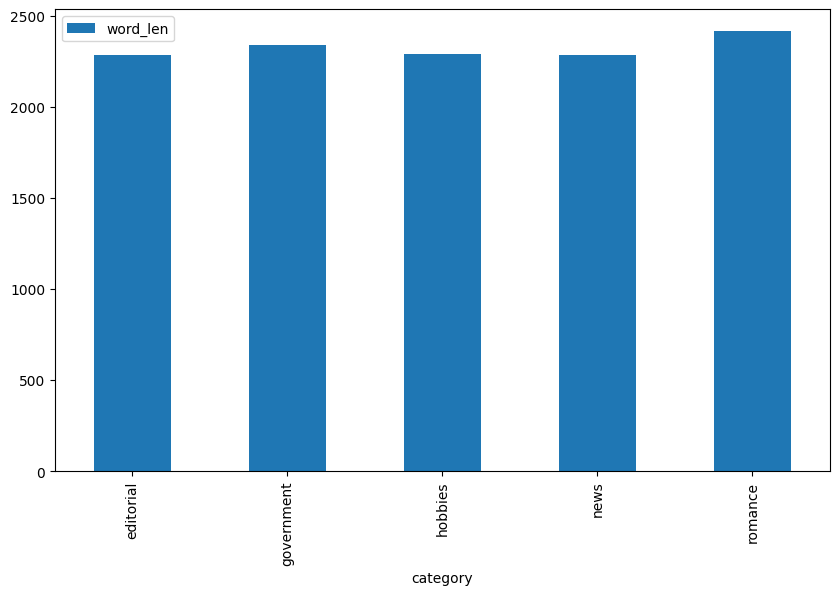

In [11]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [12]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [13]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?

A:
1. count_text_vectors: This data frame contains the count vectorization of the text data. Each cell represents the frequency count of a word in the corpus.

2. tfidf_text_vectors: This data frame contains the TF-IDF (Term Frequency-Inverse Document Frequency) vectorization of the text data. Each cell represents the importance of a word in a document relative to the corpus.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections.

In [14]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.


In [18]:
# Get all categories in the Brown Corpus
categories = brown.categories()
print(categories)

['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# This code was supported with the help of GitHub Copilot

categories = ['editorial', 'government', 'news', 'romance', 'hobbies']

category_list = []
file_ids = []
texts = []

for category in categories:
    for file_id in brown.fileids(categories=category):
        category_list.append(category)
        file_ids.append(file_id)
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts

tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.7)
tfidf_vectors = tfidf_vectorizer.fit_transform(df['text'])

# Fit NMF model
nmf_model = NMF(n_components=5, random_state=42)
W_matrix = nmf_model.fit_transform(tfidf_vectors)
H_matrix = nmf_model.components_

# Display topics
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1]
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]] * 100.0 / total)))

display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out())

nmf_topics = W_matrix.argmax(axis=1)
topic_category_tally = {i: Counter() for i in range(5)}

for i, topic in enumerate(nmf_topics):
    topic_category_tally[topic][df['category'].iloc[i]] += 1

# Print the tally
for topic, tally in topic_category_tally.items():
    print(f"\nTopic {topic}:")
    for category, count in tally.items():
        print(f"  {category}: {count}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.39)

Topic 01
  said (0.87)
  didn (0.46)
  ll (0.45)
  thought (0.41)
  just (0.40)

Topic 02
  state (0.40)
  development (0.37)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.59)
  mr (0.77)
  said (0.65)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.75)
  ball (0.72)
  baseball (0.71)
  team (0.67)

Topic 0:
  editorial: 20
  government: 4
  news: 8

Topic 1:
  editorial: 5
  romance: 29
  hobbies: 8

Topic 2:
  editorial: 2
  government: 26
  news: 10
  hobbies: 26

Topic 3:
  news: 18
  hobbies: 1

Topic 4:
  news: 8
  hobbies: 1


Q: How does your five-topic NMF model compare to the original Brown categories?

A:Topic 00:

Major categories: editorial (20), government (4), news (8)

Interpretation: This topic seems to be predominantly represented by the editorial category, suggesting it covers themes related to political or opinion pieces, possibly discussing prominent figures like the president and international relations.

Topic 01:

Major categories: romance (29), hobbies (8), editorial (5)

Interpretation: This topic includes a significant number of articles from the romance category, indicating themes related to personal relationships and informal dialogues.

Topic 02:

Major categories: government (26), hobbies (26), news (10), editorial (2)

Interpretation: The articles classified under this topic are mostly from government and hobbies categories, suggesting a focus on state affairs, development, taxes, and possibly structured activities or programs.

Topic 03:

Major categories: news (18), hobbies (1)

Interpretation: This topic is primarily composed of news articles, indicating that it deals with reported events, personal titles (Mr., Mrs., Miss), and possibly personal stories involving cars.

Topic 04:

Major categories: news (8), hobbies (1)

Interpretation: Articles in this topic are majorly from the news category, pointing towards a thematic concentration on sports, particularly baseball and teams.

Overall, the model shows a reasonable alignment with the original Brown categories, with each NMF topic capturing distinct themes that correspond to specific categories in the Brown Corpus. This alignment indicates that the NMF model is effective in identifying underlying topics that are coherent with the predefined categories.


## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.


In [24]:
# This code was supported with the help of GitHub Copilot
categories = ['editorial', 'government', 'news', 'romance', 'hobbies']

category_list = []
file_ids = []
texts = []

for category in categories:
    for file_id in brown.fileids(categories=category):
        category_list.append(category)
        file_ids.append(file_id)
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts

tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.7)
tfidf_vectors = tfidf_vectorizer.fit_transform(df['text'])

# Fit LSA model
lsa_model = TruncatedSVD(n_components=5, random_state=42)
lsa_matrix = lsa_model.fit_transform(tfidf_vectors)

# Display topics
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1]  # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]] * 100.0 / total)))

#display_topics(lsa_model, tfidf_vectorizer.get_feature_names_out())

# Tally Brown categories for each topic
lsa_topics = lsa_matrix.argmax(axis=1)
topic_category_tally = {i: Counter() for i in range(5)}

for i, topic in enumerate(lsa_topics):
    topic_category_tally[topic][df['category'].iloc[i]] += 1

# Print the tally
for topic, tally in topic_category_tally.items():
    print(f"\nTopic {topic}:")
    for category, count in tally.items():
        print(f"  {category}: {count}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic 0:
  editorial: 27
  government: 30
  news: 34
  romance: 22
  hobbies: 36

Topic 1:
  romance: 7

Topic 2:

Topic 3:
  news: 3

Topic 4:
  news: 7


Q: How does your five-topic LSA model compare to the original Brown categories?

A:

Topic 00:

Major categories: editorial (27), government (30), news (34), romance (22), hobbies (36)

Interpretation: This topic is quite diverse, covering a range of subjects such as editorials, government, news, romance, and hobbies. The presence of words like "said," "mr," and "mrs" indicates that it might be focused on reported speech or narratives involving people.

Topic 01:

Major categories: romance (7)

Interpretation: This topic is predominantly associated with the romance category. The frequent use of words like "said," "ll," and "didn" suggests that it includes conversational or narrative elements typical of romance stories.

Topic 02:

Major categories: None listed

Interpretation: Missing data for this topic makes it difficult to interpret. However, the presence of words like "mrs," "mr," "kennedy," and "president" suggests it might relate to personal or political narratives.

Topic 03:

Major categories: news (3)

Interpretation: This topic includes words like "mrs," "club," "game," "jr," and "dallas," indicating it may be focused on social events, sports, or community news.

Topic 04:

Major categories: news (7)

Interpretation: This topic is closely related to sports, as indicated by words like "game," "league," "baseball," "ball," and "team." It seems to cover sports news and related activities.


Overall, the LSA model shows some alignment with the original Brown categories, particularly in identifying topics related to romance and sports. However, other topics appear more mixed, reflecting the diverse nature of the corpus. The LSA model provides a useful but not perfect segmentation of the text into coherent topics.

In [23]:
# call display_topics on your model
display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  ruth (0.44)
  mounting (0.25)
  mouth (0.22)
  stared (0.20)
  maintains (0.17)

Topic 01
  ruth (3.19)
  literally (2.31)
  devoted (2.22)
  thinks (1.86)
  gold (1.66)

Topic 02
  mouth (3.19)
  mounting (1.72)
  ruth (1.14)
  jurisdiction (0.77)
  prescribed (0.75)

Topic 03
  mouth (21.30)
  clouds (4.61)
  future (4.23)
  johnson (4.03)
  cycle (3.82)

Topic 04
  future (4.14)
  lawyers (2.95)
  baseball (2.93)
  ball (2.77)
  taylor (2.69)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What is your interpretation of the display topics output?

A:
Topic 00: Words like "ruth," "mounting," "mouth," and "stared" suggest this topic might be related to personal
interactions or narratives, possibly focusing on individual experiences or emotions.

Topic 01: The presence of "ruth," "literally," "devoted," "thinks," and "gold" indicates this topic may revolve around personal thoughts, dedication, and perhaps financial matters or wealth.

Topic 02: With words like "mouth," "mounting," "ruth," "jurisdiction," and "prescribed," this topic could be about legal or authoritative discussions, possibly mixed with personal elements.

Topic 03: Dominated by "mouth," "clouds," "future," "johnson," and "cycle," this topic seems to focus on future-oriented discussions, possibly related to weather, personal predictions, or cycles in different contexts.

Topic 04: Words such as "future," "lawyers," "baseball," "ball," and "taylor" suggest this topic could encompass legal matters, sports (specifically baseball), and future events or plans.

The model has identified distinct themes, but the overlap of certain words like "ruth" and "mouth" across multiple topics indicates some common threads or ambiguities in the categorization.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization.

In [25]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What inference do you draw from the displayed topics for your LDA model?

A:

 Based on the top terms in each topic, you can infer the main themes or subjects represented by each topic.
For instance, if a topic has high weights for terms like "government," "policy," and "election," it likely represents political content.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: Tally the Brown categories within each LDA topic by checking which documents (and their categories) are most strongly associated with each topic.

Compare the dominant categories within LDA topics to the predefined categories in the Brown corpus to see how well they align.

In [34]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A:

Principal Component Scatterplot:

1. Distribution of Topics: The scatterplot shows the distribution of topics across two principal components. Each point represents a document, and its position indicates how it relates to the topics.

2. Topic Separation: If the points form distinct clusters, it indicates clear topic separation. Overlapping clusters suggest that some topics share common terms, making them less distinct.

Salient Terms Graph:
1. Key Terms Identification: The graph highlights the most significant terms for each topic. These terms have the highest weights in their respective topics.
2. Term Relevance: Understanding which terms are most salient can help interpret the meaning and focus of each topic.

## Conclusion:
The scatterplot and salient terms graph together provide a comprehensive view of how well the topics are differentiated and what key terms define each topic. This analysis helps in understanding the underlying structure of the topics and their relevance.


In [37]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended texlive-pictures
  texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-fre

In [40]:
!cp /content/drive/MyDrive/ADS-509-01/Module5/TopicModeling.ipynb

cp: missing destination file operand after '/content/drive/MyDrive/ADS-509-01/Module5/TopicModeling.ipynb'
Try 'cp --help' for more information.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [41]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/ADS-509-01/Module5/TopicModeling.ipynb"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[NbConvertApp] Converting notebook /content/drive/MyDrive/ADS-509-01/Module5/TopicModeling.ipynb to PDF
[NbConvertApp] Support files will be in TopicModeling_files/
[NbConvertApp] Making directory ./TopicModeling_files
[NbConvertApp] Writing 102306 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 122131 bytes to /content/drive/MyDrive/ADS-509-01/Module5/TopicModeling.pdf
